#### 7. Implementing SVMs

In [18]:
# !pip install ucimlrepo

In [2]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt

In [3]:
# !! DO NOT MODIFY THIS CELL !!

# Download and preprocess the dataset.
# fetch dataset
heart_disease = fetch_ucirepo(id=45)
X = heart_disease.data.features
# Convert categorical features into one-hot encode
categorical_features = ['cp','thal','slope','restecg']
X = pd.get_dummies(X, columns=categorical_features)

y = heart_disease.data.targets
print(f"Number of samples in all full dataset is: {len(X)}.")

# Check if our train set has missing value
na_in_features = X.isna().any(axis=1).sum()
na_in_trainY = y.isna().sum()
print(f"Number of rows with missing values in features: {na_in_features}")

# Drop the rows with missing values.
indices_with_nan = X.index[X.isna().any(axis=1)]
X = X.drop(indices_with_nan)
y = y.drop(indices_with_nan)

# Divide train/test
np.random.seed(6464)
msk = np.random.rand(len(X)) < 0.75
X_train = X[msk]
X_test = X[~msk]
y_train = y[msk]
y_test = y[~msk]

# Convert problem to binary problem
X_train = np.array(X_train,dtype='float')
X_test = np.array(X_test,dtype='float')
y_train = np.array([-1 if i==0 else 1 for i in y_train.values],dtype='float')
y_test = np.array([-1 if i==0 else 1 for i in y_test.values],dtype='float')

print(f"Shapes: X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")

Number of samples in all full dataset is: 303.
Number of rows with missing values in features: 4
Shapes: X_train: (216, 22), y_train: (216,), X_test: (83, 22), y_test: (83,)


In [4]:
# Normalize X_train and X_test using the statistics of X_train.
# 1. Compute the mean and standard deviation for each feature in X_train
# 2. Subtract the mean from each feature and divide by the standard deviation
#    for both X_train and X_test.
mean_X_train = np.mean(X_train,axis=0)
std_X_train = np.std(X_train,axis=0)

X_train_normalized = (X_train - mean_X_train)/std_X_train
X_test_normalized = (X_test - mean_X_train)/std_X_train

#### Why use train mean and std  
- **Prevent Data Leakage:** Using test data for normalization would leak information, leading to overly optimistic results.  
- **Real-World Consistency:** In deployment, only training data statistics are available, so the model must generalize based on them.  
- **Fair Evaluation:** Ensures test data follows the same distribution as training data for an unbiased assessment.  


In [5]:
# Print the mean and standard deviation of the first and last feature.
print("X_train First Feature")
print("----------------------------")
print(f"Mean: {mean_X_train[0]:.2f}")
print(f"Standard deviation: {std_X_train[0]:.2f} \n")


print("X_train Last Feature")
print("----------------------------")
print(f"Mean: {mean_X_train[-1]:.2f}")
print(f"Standard deviation: {std_X_train[-1]:.2f}")

X_train First Feature
----------------------------
Mean: 54.99
Standard deviation: 9.08 

X_train Last Feature
----------------------------
Mean: 0.50
Standard deviation: 0.50


In [6]:
# Train SVM

# Complete the `trainSVM` function to find the optimal w and b that minimize
# the primal SVM objective given in the write-up.
# The function takes three inputs:
# - trainX: the normalized train features with shape (#train_samples, #features)
# - trainY: train labels with shape (#train_samples,)
# - C: C parameter of the minimization problem
# The function should return a three-tuple with:
# - w: the weight vector with shape (#features,)
# - b: the bias. A scalar with shape (1,)
# - xi: the slack variables with shape (#train_samples,)

# You can use cvxpy that we imported as cp
# You may find cp.Variable, cp.Minimize, cp.Problem useful
# For the problem solver, prefer the default, cp.CLARABEL

def trainSVM(X_train_normalized, y_train, C):
    n_features = X_train_normalized.shape[1]

    # Define variables
    w = cp.Variable(n_features)
    b = cp.Variable()
    xi = cp.Variable(X_train_normalized.shape[0])

    constraints = [
    # SVM constraint
    cp.multiply(y_train, (X_train_normalized @ w + b)) >= 1 - xi,  
    # Slack variables must be non-negative 
    xi >= 0  
    ]

    # Objective function
    objective = cp.Minimize(0.5 * cp.norm(w, 2)**2 + C * cp.sum(xi))

    # Solve the problem
    problem = cp.Problem(objective, constraints)
    problem.solve()

    return w.value, b.value, xi.value

In [7]:
# Solve SVM with C = 1 and print the first three weights, b and the first
# three slack variables as instructed in the write-up
w_C1, b_C1, xi_C1 = trainSVM(X_train_normalized, y_train, C=1)

print(f"First 3 weights:\n{w_C1[:3]}")
print(f"Bias: {b_C1:.4f}")
print(f"First 3 slack variables:\n{xi_C1[:3]}")

First 3 weights:
[-0.01280084  0.51706872  0.27813637]
Bias: 0.0811
First 3 slack variables:
[-1.70119328e-10 -1.64395885e-10 -1.69587409e-10]


In [8]:
# Solve SVM with C = 0 and print the first three weights, b and the first
# three slack variables as instructed in the write-up
w_C0, b_C0, xi_C0 = trainSVM(X_train_normalized, y_train, C=0)

print(f"First 3 weights:\n{w_C0[:3]}")
print(f"Bias:{b_C0:.4f}")
print(f"First 3 slack variables:\n{xi_C0[:3]}")

First 3 weights:
[ 3.09523259e-06 -8.18802636e-06 -9.46615246e-06]
Bias:-10.4476
First 3 slack variables:
[429.58840105 434.02071004 414.34670026]


#### Explanation of the different C outputs
This difference arises because **C controls the trade-off between maximizing the margin and minimizing classification errors**. With **C = 0**, the optimization focuses only on maximizing the margin without penalizing misclassified points, allowing larger slack variables (ξ). However, when **C > 0**, the term \( C \sum \xi_i \) is introduced in the objective function, enforcing a stricter penalty for misclassification, thus reducing slack values.

This explains why we introduce the **\( C \sum \xi_i \)** term in Soft-SVM—it ensures that we balance margin maximization with classification accuracy. Without it, the model would ignore classification errors entirely.


In [9]:
# Eval SVM

# Write a function to evaluate the SVM model given its `w` and `b` parameters
# on evaluation data `X_eval` and true labels `y_eval`.
#  1. Estimate the labels of `X_eval`.
#  2. Return the ratio of accurately estimated labels by comparing with `y_eval`.
def evalSVM(X_eval, y_eval, w, b):  
    y_pred = np.sign(np.dot(X_eval, w) + b)  
    accuracy = np.mean(y_pred == y_eval)  
    return accuracy 

In [14]:
train_accuracies = []
test_accuracies = []
C_values = []

# Given C values based on homework specifications
a_values = [1, 3, 6]  
q_values = [-4, -3, -2, -1, 0, 1]  
C_possibilities = [a * (10 ** q) for a in a_values for q in q_values]  

for C in C_possibilities:  
    w, b, _ = trainSVM(X_train_normalized, y_train, C)  
    train_accuracy = evalSVM(X_train_normalized, y_train, w, b)  
    test_accuracy = evalSVM(X_test_normalized, y_test, w, b)  
    
    C_values.append(C)  
    train_accuracies.append(train_accuracy)  
    test_accuracies.append(test_accuracy)  

# Sort lists based on C_values while keeping corresponding values aligned
sorted_data = sorted(zip(C_values, train_accuracies, test_accuracies), key=lambda x: x[0])
C_values, train_accuracies, test_accuracies = zip(*sorted_data)

# Convert tuples back to lists
C_values = list(C_values)
train_accuracies = list(train_accuracies)
test_accuracies = list(test_accuracies)


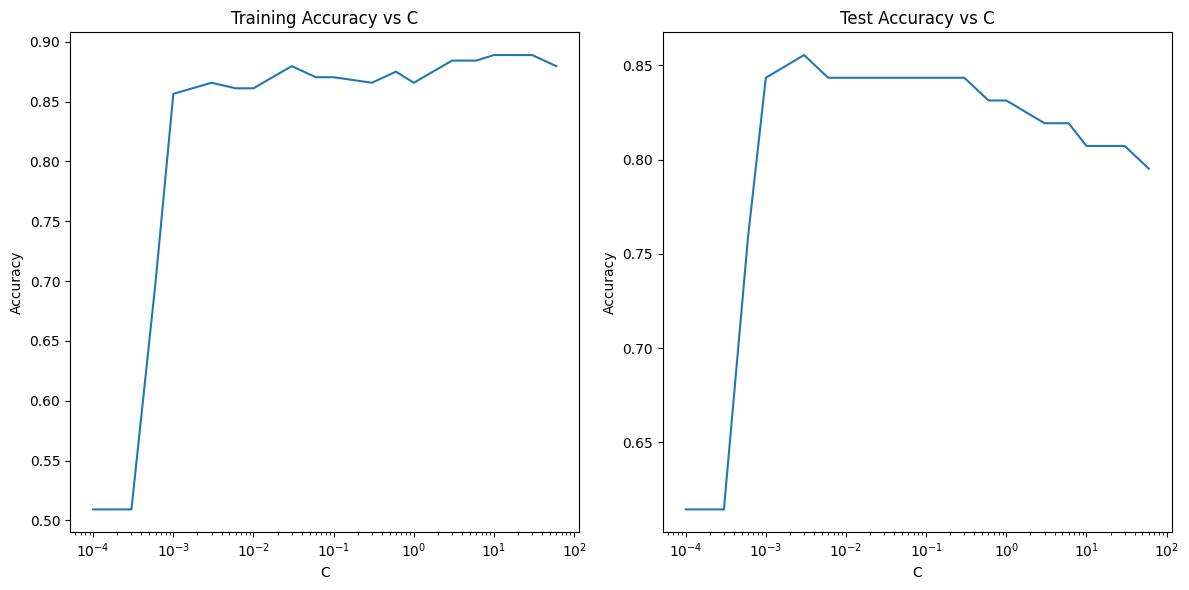

In [15]:
# Plotting and reporting the desired values
plt.figure(figsize=(12,6))  
plt.subplot(1, 2, 1)  
plt.plot(C_values, train_accuracies)  
plt.xscale('log')  
plt.title('Training Accuracy vs C')  
plt.xlabel('C')  
plt.ylabel('Accuracy')  

plt.subplot(1, 2, 2)  
plt.plot(C_values, test_accuracies)  
plt.xscale('log')  
plt.title('Test Accuracy vs C')  
plt.xlabel('C')  
plt.ylabel('Accuracy')  

plt.tight_layout()  
plt.show()  

In [16]:
# Desired values
best_train_C = C_values[np.argmax(train_accuracies)]  
best_train_accuracy = max(train_accuracies) 

print(f"Best Training C: {best_train_C}\nAccuracy: {best_train_accuracy:.2f}") 

Best Training C: 10
Accuracy: 0.89


In [17]:
best_test_C = C_values[np.argmax(test_accuracies)]  
best_test_accuracy = max(test_accuracies)  

 
print(f"Best Test C: {best_test_C}\nAccuracy: {best_test_accuracy:.2f}") 

Best Test C: 0.003
Accuracy: 0.86
